# Introduction

In [ ]:
# Import built-in Python libraries
from matplotlib import pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from shutil import copy

%tensorflow_version 2.x
import tensorflow as tf

import numpy as np
import scipy.io.wavfile
import librosa
import glob
import os
import pickle
import time
import datetime
import importlib
import zipfile

In [ ]:
# Path variables
drive_path = "/content/drive/My Drive/KInsekten/"

data_path         = drive_path + "data/Potatamis/"
figures_path      = drive_path + "figures/"
scripts_path      = drive_path + "scripts/"
pot_models_path   = drive_path + "models/Potatamis/"
keogh_models_path = drive_path + "models/Keogh/"

# Plot font sizes
title_size = 32
label_size = 27
ticks_size = 27
fig_size   = (20, 14)

In [ ]:
strategy = 'CPU' #@param ["CPU", "GPU", "TPU"]

if strategy is 'CPU':
  strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
  print('/device:CPU:0')
elif strategy is 'GPU':
  if tf.config.list_physical_devices('GPU'):
    #policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16') 
    #tf.keras.mixed_precision.experimental.set_policy(policy) 
    tf.test.gpu_device_name()
    strategy = tf.distribute.MirroredStrategy()
  else:
    print('No GPU detected')
elif strategy is 'TPU':
  try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.experimental.TPUStrategy(resolver)
  except ValueError:
    print('No TPU detected')

/device:CPU:0


In [ ]:
os.chdir(drive_path)
import wingbeats
from wingbeats.modelling import *
from wingbeats.processing import *
from wingbeats.xai import *

In [ ]:
#!git clone https://github.com/scikit-learn-contrib/imbalanced-learn.git

In [ ]:
#!git clone https://github.com/albermax/innvestigate.git -b updates_towards_tf2.0 --single-branch

In [ ]:
from imblearn.over_sampling._smote import SMOTE
from innvestigate.innvestigate.analyzer import gradient_based as G # for attention methods such as GBP or LRP

In [ ]:
#!pip install foolbox
import foolbox as fb # for adv.attacks

# Load signals

In [ ]:
# Create temporary local directory to copy data from Drive 
os.chdir('/content')
if not os.path.exists('KInsekten'):
    os.mkdir('KInsekten')
if not os.path.exists('KInsekten/Potatamis'):
    os.mkdir('KInsekten/Potatamis')
if not os.path.exists('KInsekten/Potatamis/Test'): 
    os.mkdir('KInsekten/Potatamis/Test')
if not os.path.exists('KInsekten/Potatamis_zip'):
    os.mkdir('KInsekten/Potatamis_zip')
time.sleep(10) # wait until Colab creates the new directories

# Copy files from Drive (zipped amplitudes and label vectors)
start_time = time.time()
copy(data_path + 'Test_amplitudes.zip', 'KInsekten/Potatamis_zip')
print('Test_amplitudes.zip copied')
copy(data_path + 'Test_labels.pickle', 'KInsekten/Potatamis/Test')
print('Test_labels.pickle copied')
print("%s seconds\n" % int(time.time() - start_time))

# Unzip the files locally
start_time = time.time()
with zipfile.ZipFile('/content/KInsekten/Potatamis_zip/Test_amplitudes.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/KInsekten/Potatamis/Test')  
print('Test unzipped')
print("%s seconds\n" % int(time.time() - start_time))

Test_amplitudes.zip copied
Test_labels.pickle copied
7 seconds

Test unzipped
10 seconds



Species and Genus encoding

In [ ]:
# Dictionary of genera with the included species
genus_species_dict = {
    'Aedes': ['Ae_aegypti', 'Ae_albopictus'],
    'Anopheles': ['An_arabiensis', 'An_gambiae'],
    'Culex': ['Cu_pipiens', 'Cu_quinquefasciatus']
}

# Store species from the dictionary values (list flattening)
species = [s for l in list(genus_species_dict.values()) for s in l]
print(species)

# Store genus from the keys
genus = list(genus_species_dict.keys())
print(genus)

# Store genus that each species belongs to as a Look-Up Table
genus_mapping = []
for val, gen_ind in zip(genus_species_dict.values(), range(len(genus))):
  genus_mapping += [gen_ind] * len(val)
print(genus_mapping)

['Ae_aegypti', 'Ae_albopictus', 'An_arabiensis', 'An_gambiae', 'Cu_pipiens', 'Cu_quinquefasciatus']
['Aedes', 'Anopheles', 'Culex']
[0, 0, 1, 1, 2, 2]


Class Embeddings

In [ ]:
# Similarity matrix
S = np.identity(len(species))

diag_ind = 0
for gen_ind in range(len(genus)):

  # How many species belong to the current genus index?
  spec_in_gen = genus_mapping.count(gen_ind)
  
  # Each sub-block corresponding to a genus will be filled with 1/2
  # except along the diagonal which has 1's
  for i in range(spec_in_gen):
    for j in range(spec_in_gen):
      if i != j:
        S[diag_ind+i, diag_ind+j] = 1/2

  diag_ind += spec_in_gen
print(S)

[[1.  0.5 0.  0.  0.  0. ]
 [0.5 1.  0.  0.  0.  0. ]
 [0.  0.  1.  0.5 0.  0. ]
 [0.  0.  0.5 1.  0.  0. ]
 [0.  0.  0.  0.  1.  0.5]
 [0.  0.  0.  0.  0.5 1. ]]


In [ ]:
# Compute matrix of embedded vectors from similarity matrix
emb_matrix = np.asarray( unitsphere_embedding(S), dtype = np.float32 )
genus_mapping = np.asarray(genus_mapping)
print(np.round(emb_matrix, 4))

[[1.    0.    0.    0.    0.    0.   ]
 [0.5   0.866 0.    0.    0.    0.   ]
 [0.    0.    1.    0.    0.    0.   ]
 [0.    0.    0.5   0.866 0.    0.   ]
 [0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.5   0.866]]


Construct data matrix X_test

In [ ]:
# The training set and the validation set are mixed together
X_test, y_test = [], []
sampling_rate = 8000

print('\nLoading test set into X_test...')
with open('/content/KInsekten/Potatamis/Test/Test_amplitudes.pickle', 'rb') as f: # signals
  X_test = pickle.load(f)

with open('/content/KInsekten/Potatamis/Test/Test_labels.pickle', 'rb') as f: # labels
  temp = pickle.load(f)
  for lab in temp:
    y_test.append([genus_mapping[lab], lab])
print('Total: ' + str(len(X_test)))


Loading test set into X_test...
Total: 55916


In [ ]:
# Normalize amplitudes and map them to [-1, 1]
for i in range(len(X_test)):
  X_test[i] = X_test[i] / np.max(np.abs(X_test[i])) 

# Data preprocessing

In [ ]:
# Define initial training parameters
epochs = 30
batch_size = 64
drop_rate = 0.5 
format_params = {'psd':     {'window': 'hanning',
                             'in_shape': (129, 1),
                             'noverlap': 192},
                 'spectro': {'window': tf.signal.hann_window,
                             'in_shape': (129, 113, 3),
                             'noverlap': 256-256//6}}
input_formats = list(format_params.keys())

# For Welch-Transform
nperseg  = 256        
cutoff   = None

In [ ]:
# Define dictionary of model constructors, output shapes and hyperparameters
models_dict = {'SimpleCls':    {'constructor': build_simple_classifier, 
                                'out_shape': len(species),
                                'lr_reg': {input_formats[0]: (1e-3, 1e-4),
                                           input_formats[1]: (5e-4, 1e-3)},
                                'loss': 'sparse_categorical_crossentropy',
                                'metrics': ['accuracy']}, 
               
               'SimpleEmbCls': {'constructor': build_simple_embedder_classifier, 
                                'out_shape': [len(species), len(species)],
                                'lr_reg': {input_formats[0]: (5e-3, 1e-2),
                                           input_formats[1]: (5e-3, 5e-3)},
                                'loss': {"embedding": embedding_loss(emb_matrix),
                                         "species": 'sparse_categorical_crossentropy'},
                                'metrics': {"embedding": embedding_similarity(emb_matrix), 
                                            "species": 'accuracy'}},
               
               'HieraCls':     {'constructor': build_hiera_classifier, 
                                'out_shape': [len(genus), len(species)],
                                'lr_reg': {input_formats[0]: (5e-4, 1e-3),
                                           input_formats[1]: (5e-4, 5e-4)},
                                'loss': {"genus":   'sparse_categorical_crossentropy', 
                                         "species": 'sparse_categorical_crossentropy'},
                                'metrics': {"genus": 'accuracy', 
                                            "species": 'accuracy'}},
               
               'HieraEmbCls':  {'constructor': build_hiera_embedder_classifier, 
                                'out_shape': [len(species), len(genus), len(species)],
                                'lr_reg': {input_formats[0]: (5e-3, 1e-3),
                                           input_formats[1]: (5e-3, 1e-3)},
                                'loss': {"embedding": embedding_loss(emb_matrix), 
                                         "genus": 'sparse_categorical_crossentropy',
                                         "species": 'sparse_categorical_crossentropy'},
                                'metrics': {"embedding": embedding_similarity(emb_matrix), 
                                            "genus": 'accuracy', 
                                            "species": 'accuracy'}}
              } # end dict

model_names = list(models_dict.keys())

In [ ]:
# Load mean spectrogram
with open(data_path + 'pot_mean.pickle', 'rb') as f:
  mean_train_tensor = pickle.load(f)

with open(data_path + 'pot_std.pickle', 'rb') as f:
  std_train_tensor = pickle.load(f)

In [ ]:
# Choose model to load
inp_form = 'spectro'
model_name = model_names[0]
#full_name  = model_name + '_' + inp_form
full_name  = model_name + '_' + inp_form + '_mobile'
print(full_name)

# Derive psd and path variables
window   = format_params[inp_form]['window']
in_shape = format_params[inp_form]['in_shape']
noverlap = format_params[inp_form]['noverlap']
model_base_dir    = pot_models_path + model_name +  '/' + inp_form + '/'
#load_weights_file = model_base_dir + full_name + '_frozen.h5'
load_weights_file = model_base_dir + full_name + '.h5' # Mobile/Efficient
histories_dir     = model_base_dir + 'histories/'

SimpleCls_spectro_mobile


In [ ]:
# Preprocess test set
# Note: we are only interested in the species scores here
test_set = preprocess_dataset(X_test if inp_form == 'spectro' else list(np.copy(X_test)), 
                              y_test, 'SimpleCls', inp_form, sampling_rate, batch_size,
                              window, nperseg, noverlap, cutoff, shuffle = True, prefetch = False)

In [ ]:
# Roll out models dictionary
constructor = models_dict[model_name]['constructor']
out_shape   = models_dict[model_name]['out_shape']
loss        = models_dict[model_name]['loss']
metrics     = models_dict[model_name]['metrics']

In [ ]:
# Build and compile
tf.keras.backend.clear_session() # avoid stacking graphs on one another
cnn_name = 'CNN_Blocks_' + model_name
with strategy.scope():
  if inp_form == 'psd':
    cnn = CNN1D(drop_rate, name = cnn_name) # Name needs to be exactly as in Kaggle!
  elif inp_form == 'spectro':
    if 'mobile' in full_name:
      cnn = CNN_Mobile(in_shape, 0.25, drop_rate, name = 'CNN_Blocks_mobile')
    else:
      cnn = CNN2D(drop_rate, name = cnn_name) 
      
  model = constructor(in_shape, out_shape, cnn, input_name = inp_form, model_name = full_name,
                      training = False)

  # Note: When loading weights from a frozen model, you need to first also freeze those layers again
  # Note: Don't freeze any layer in MobileNet
  if 'mobile' not in full_name:
    cnn_layer = model.get_layer(cnn_name)
    cnn_layer.bnorm_0.trainable = False
    cnn_layer.block_1.trainable = False
    cnn_layer.block_2.trainable = False

  # Initialize pretrained weights 
  model.load_weights(load_weights_file)

  # Only now can you unfreeze these layers
  if 'mobile' not in full_name:
    cnn_layer.bnorm_0.trainable = True
    cnn_layer.block_1.trainable = True
    cnn_layer.block_2.trainable = True

  model.compile(tf.keras.optimizers.Adam(), loss = loss, metrics = metrics)

# Attention maps 

## Example Spectro

In [ ]:
# Strip model of the softmax layer
# Note: For multi-output models cut off layers not responsible for species classif.
model = tf.keras.models.Model(model.input, model.layers[-3].output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spectro (InputLayer)         [(None, 129, 113, 3)]     0         
_________________________________________________________________
CNN_Blocks_SimpleEmbCls (CNN (None, 256)               394604    
_________________________________________________________________
dense_emb (Dense)            (None, 6)                 1542      
_________________________________________________________________
dense_species (DenseBlock)   (None, 6)                 66        
Total params: 396,212
Trainable params: 395,202
Non-trainable params: 1,010
_________________________________________________________________


In [ ]:
# Pick one example
target_ind = 0
for sig, lab in test_set:
  if lab == target_ind:
    ex_spec = sig
    ex_lab  = lab
    print(ex_spec.shape)
    break

# Change format for Gradient Tape
ex_spec = tf.expand_dims(ex_spec, axis=0)

(129, 113, 3)


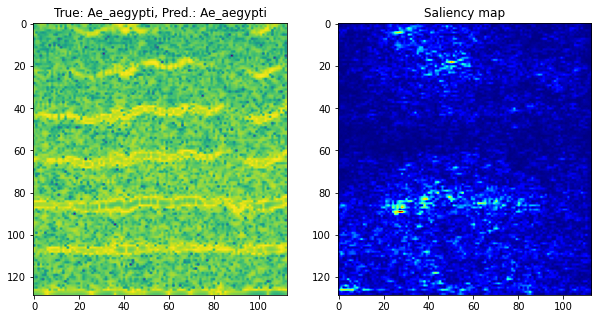

In [ ]:
# Compute sal. map and make prediction
hm, pred  = saliency_map(model, tf.Variable(ex_spec, dtype=tf.float32))  
pred_spec = np.argmax(pred)

# Plot the example along with the saliency map
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(ex_spec[0,:,:,0], aspect = 'auto', cmap='viridis_r')
plt.title('True: ' + species[ex_lab] + ', Pred.: ' + species[pred_spec])

plt.subplot(122)
plt.imshow(hm, cmap="jet", aspect = 'auto')
plt.title('Saliency map')
plt.show()

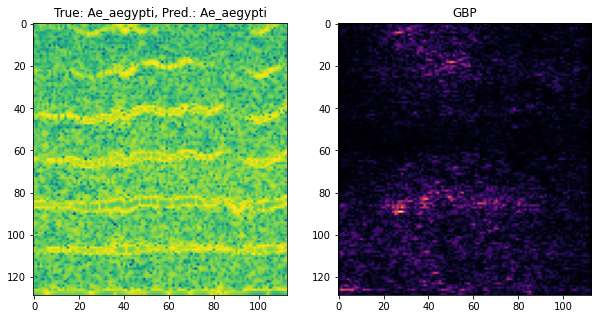

In [ ]:
# Compute GBP and make prediction
hm, pred  = guided_back_prop(model, tf.Variable(ex_spec, dtype=tf.float32))  
pred_spec = np.argmax(pred)

# Plot the example along with the saliency map
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(ex_spec[0,:,:,0], aspect = 'auto', cmap='viridis_r')
plt.title('True: ' + species[ex_lab] + ', Pred.: ' + species[pred_spec])

plt.subplot(122)
plt.imshow(hm, cmap="inferno", aspect = 'auto')
plt.title('GBP')
plt.show()

## Comparison

Select samples

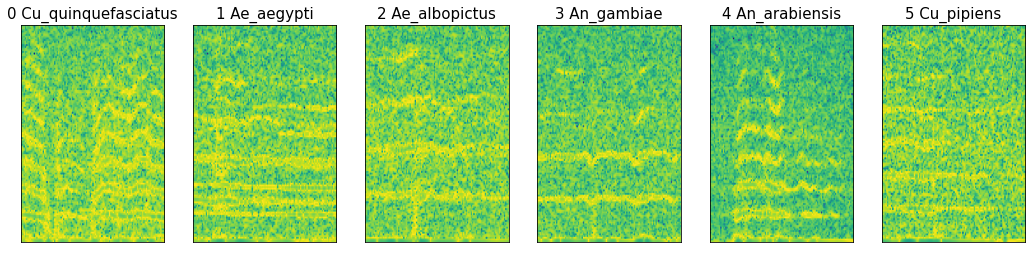

In [ ]:
# Pick one example for each species
ex_specs, ex_labs = [], []
i = 0
plt.figure(figsize = (3*len(species), 4))
for sig, lab in test_set:
  if lab not in ex_labs:
    ex_specs.append( tf.expand_dims(sig, axis=0) )
    ex_labs.append(lab.numpy())
    plt.subplot(1, len(species), i+1)
    plt.imshow(sig[:,:,0], aspect = 'auto', cmap='viridis_r')
    plt.title(str(i) + ' ' + species[lab], fontsize = 15)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if len(ex_specs) == len(species):
      break
plt.show()

In [ ]:
# Select one interesting sample per genus
ex_spec_ind = range(6)
ex_specs = np.asarray(ex_specs)[ex_spec_ind]
ex_labs  = np.asarray(ex_labs)[ex_spec_ind]
print(np.asarray(species)[ex_labs])

['Cu_quinquefasciatus' 'Ae_aegypti' 'Ae_albopictus' 'An_gambiae'
 'An_arabiensis' 'Cu_pipiens']


Load models

In [ ]:
# Choose model to load
inp_form = 'spectro'

# Derive psd and path variables
window   = format_params[inp_form]['window']
in_shape = format_params[inp_form]['in_shape']

trim_layer_ind = [-2, -3, -3, -4]

models = []
for model_name, trim_ind in zip(model_names, trim_layer_ind):

  full_name = model_name + '_' + inp_form
  print(full_name)

  model_base_dir    = pot_models_path + model_name +  '/' + inp_form + '/'
  load_weights_file = model_base_dir + full_name + '_frozen.h5'

  # Roll out models dictionary
  constructor = models_dict[model_name]['constructor']
  out_shape   = models_dict[model_name]['out_shape']
  loss        = models_dict[model_name]['loss']
  metrics     = models_dict[model_name]['metrics']

  # Build and compile
  tf.keras.backend.clear_session() # avoid stacking graphs on one another
  cnn_name = 'CNN_Blocks_' + model_name
  with strategy.scope():
    cnn = CNN2D(drop_rate, name = cnn_name) 
    model = constructor(in_shape, out_shape, cnn, input_name = inp_form, model_name = full_name,
                        training = False)

    # Note: When loading weights from a frozen model, you need to first also freeze those layers again
    # Note: Don't freeze any layer in MobileNet
    cnn_layer = model.get_layer(cnn_name)
    cnn_layer.bnorm_0.trainable = False
    cnn_layer.block_1.trainable = False
    cnn_layer.block_2.trainable = False

    # Initialize pretrained weights 
    model.load_weights(load_weights_file)

    # Only now can you unfreeze these layers
    cnn_layer.bnorm_0.trainable = True
    cnn_layer.block_1.trainable = True
    cnn_layer.block_2.trainable = True

    # Trim softmax and other layers not related to species prediction
    model = tf.keras.models.Model(model.input, model.layers[trim_ind].output)

    model.compile(tf.keras.optimizers.Adam(), loss = loss, metrics = metrics)

  models.append(model)

SimpleCls_spectro
SimpleEmbCls_spectro
HieraCls_spectro
HieraEmbCls_spectro


In [ ]:
# Load MobileNet separately
model_name = 'SimpleCls'
ext = '_mobile'

# Roll out models dictionary
constructor = models_dict[model_name]['constructor']
out_shape   = models_dict[model_name]['out_shape']
loss        = models_dict[model_name]['loss']
metrics     = models_dict[model_name]['metrics']

full_name  = model_name + '_' + inp_form + ext
print(full_name)

model_base_dir    = pot_models_path + model_name +  '/' + inp_form + '/'
load_weights_file = model_base_dir + full_name + '.h5' 

# Build and compile
tf.keras.backend.clear_session() # avoid stacking graphs on one another
with strategy.scope():
  cnn = CNN_Mobile(in_shape, 0.25, drop_rate, name = 'CNN_Blocks_mobile')

  model = constructor(in_shape, out_shape, cnn, input_name = inp_form, model_name = full_name)

  # Initialize pretrained weights 
  model.load_weights(load_weights_file)

  # Trim softmax and other layers not related to species prediction
  model = tf.keras.models.Model(model.input, model.layers[-2].output)

  model.compile(tf.keras.optimizers.Adam(), loss = loss, metrics = metrics)

models.append(model)

SimpleCls_spectro_mobile
2113536/2108140 [==============================] - 0s 0us/step


In [ ]:
# Compute saliency maps
num_rows = len(models)
num_cols = len(ex_specs)
preds    = np.zeros((num_rows, num_cols))
sal_maps = np.zeros((num_rows, num_cols, ex_specs.shape[2], ex_specs.shape[3]))

for i in range(num_rows):
  for j in range(num_cols):

    hm, pred = saliency_map(models[i], tf.Variable(ex_specs[j], dtype=tf.float32))  

    sal_maps[i, j] = hm
    preds[i, j]    = np.argmax(pred, axis = -1)[0]
    
preds = np.asarray(preds, dtype = np.int8)

In [ ]:
plot_names = ['Input'] + model_names + ['MobileNet']
num_rows   = len(models) + 1

fig = plt.figure(figsize=(7 * num_cols, 5 * num_rows + 1))
for i in range(num_rows):
  for j in range(num_cols):
    plt.subplot(num_rows, num_cols, i*num_cols + j + 1)

    if i == 0: # spectrograms
      plt.imshow(ex_specs[j][0,:,:,0], aspect = 'auto', cmap='viridis_r')
      plt.title(species[ex_labs[j]], fontsize = title_size)

    else: # maps
      plt.imshow(sal_maps[i-1, j], cmap="jet", aspect = 'auto')
      plt.title(species[preds[i-1, j]], fontsize = title_size)
    
    plt.xticks([])
    plt.yticks([])

    if j == 0:
      plt.ylabel(plot_names[i], fontsize = label_size)

plt.tight_layout
fig.savefig(figures_path + 'pot_sal_all.png', bbox_inches = 'tight')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Compute GBP maps
num_rows = len(models)
num_cols = len(ex_specs)
preds    = np.zeros((num_rows, num_cols))
gbp_maps = np.zeros((num_rows, num_cols, ex_specs.shape[2], ex_specs.shape[3]))

for i in range(num_rows):
  for j in range(num_cols):

    hm, pred = guided_back_prop(models[i], tf.Variable(ex_specs[j], dtype=tf.float32))  

    gbp_maps[i, j] = hm
    preds[i, j]    = np.argmax(pred, axis = -1)[0]
    
preds = np.asarray(preds, dtype = np.int8)

In [ ]:
plot_names = ['Input'] + model_names + ['MobileNet']
num_rows   = len(models) + 1

fig = plt.figure(figsize=(7 * num_cols, 5 * num_rows + 1))
for i in range(num_rows):
  for j in range(num_cols):
    plt.subplot(num_rows, num_cols, i*num_cols + j + 1)

    if i == 0: # spectrograms
      plt.imshow(ex_specs[j][0,:,:,0], aspect = 'auto', cmap='viridis_r')
      plt.title(species[ex_labs[j]], fontsize = title_size)

    else: # maps
      plt.imshow(gbp_maps[i-1, j], cmap="inferno", aspect = 'auto')
      plt.title(species[preds[i-1, j]], fontsize = title_size)
    
    plt.xticks([])
    plt.yticks([])

    if j == 0:
      plt.ylabel(plot_names[i], fontsize = label_size)

plt.tight_layout
fig.savefig(figures_path + 'pot_gbp_all.png', bbox_inches = 'tight')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# MCDropout

(129, 113, 3)


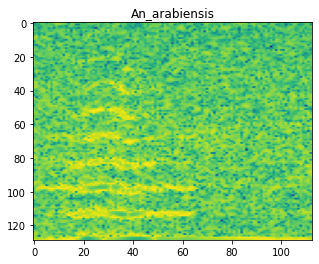

In [ ]:
num_infer = 500 # inferences for MCD

# Pick one example
target_ind = 2
for sig, lab in test_set:
  if lab == target_ind:
    ex_spec = sig
    print(ex_spec.shape)
    break

# Change format for Gradient Tape
ex_spec = tf.expand_dims(ex_spec, axis=0)

plt.figure(figsize=(5, 4))
plt.imshow(ex_spec[0,:,:,0], aspect='auto', cmap='viridis_r')
plt.title(species[target_ind])
plt.show()

In [ ]:
# Strip model of the softmax layer
# Note: For multi-output models cut off layers not responsible for species classif.
model = tf.keras.models.Model(model.input, model.layers[-2].output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spectro (InputLayer)         [(None, 129, 113, 3)]     0         
_________________________________________________________________
CNN_Blocks_mobile (CNN_Mobil (None, 256)               218544    
_________________________________________________________________
dense_species (Dense)        (None, 6)                 1542      
Total params: 220,086
Trainable params: 214,614
Non-trainable params: 5,472
_________________________________________________________________


In [ ]:
# Enable MCD
model.layers[1].mcdrop = True

In [ ]:
heatmaps = []

# Make multiple predictions and compute attention map vor every new one
for i in range(num_infer):
  
  heatmap, _ = saliency_map(model, tf.Variable(ex_spec, dtype=tf.float32))
  #heatmap, _ = guided_back_prop(model, tf.Variable(ex_spec, dtype=tf.float32))
  heatmaps.append(heatmap)

In [ ]:
# Compute quantile maps
nbins = 50
q = [0.05, 0.25, 0.5, 0.75, 0.95]
q_heatmaps = quantile_maps(heatmaps, q, nbins)

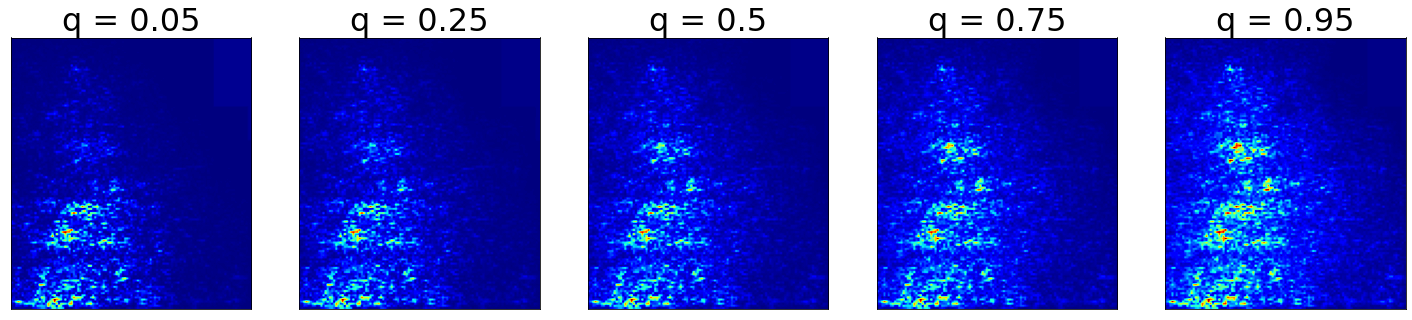

In [ ]:
# Plot SM quantiles for SimpleEmbCls
fig = plt.figure(figsize = (25, 5))
for i in range(len(q)):
  plt.subplot(1, len(q), i+1)
  plt.imshow(q_heatmaps[i], cmap='jet', aspect='auto')
  plt.title('q = ' + str(q[i]), fontsize = title_size)
  plt.xticks([])
  plt.yticks([])
fig.savefig(figures_path + 'pot_sal_quantiles_simemb.png', bbox_inches = 'tight')
plt.show()

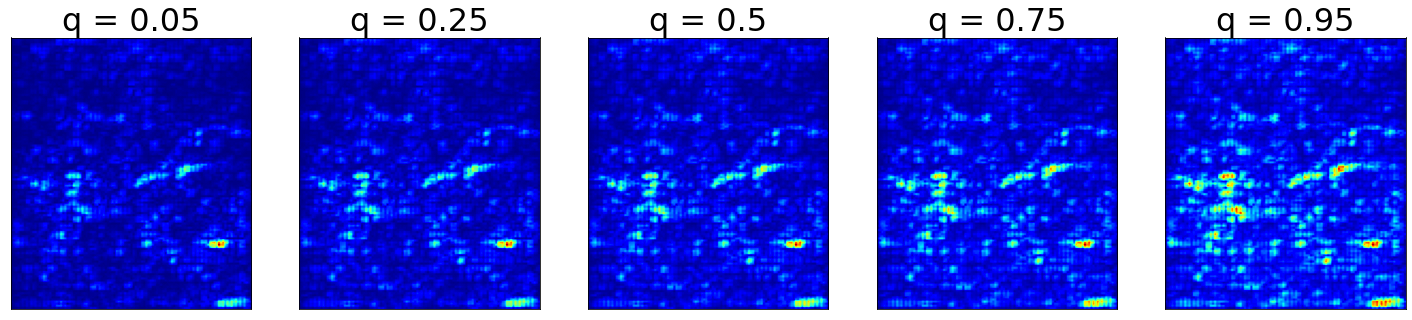

In [ ]:
# Plot SM quantiles for MobileNet
fig = plt.figure(figsize = (25, 5))
for i in range(len(q)):
  plt.subplot(1, len(q), i+1)
  plt.imshow(q_heatmaps[i], cmap='jet', aspect='auto')
  plt.title('q = ' + str(q[i]), fontsize = title_size)
  plt.xticks([])
  plt.yticks([])
fig.savefig(figures_path + 'pot_sal_quantiles_mobile.png', bbox_inches = 'tight')
plt.show()

# Pixel Flipping

In [ ]:
# Flipping parameters
percent_to_flip = 0.25
percent_step = 0.005
percents = int(percent_to_flip*100)
num_scores = int(percent_to_flip / percent_step) + 1

# MCD-Quantiles parameters
num_infer = 100
nbins = 50
q = [0.25, 0.5, 0.75]
sm_leg  = ['SM ' + str(quant) for quant in q] # For plot legends
gbp_leg = ['GBP ' + str(quant) for quant in q]

In [ ]:
# Strip model of the softmax layer
# Note: For multi-output models cut off layers not responsible for species classif.
model = tf.keras.models.Model(model.input, model.layers[-2].output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spectro (InputLayer)         [(None, 129, 113, 3)]     0         
_________________________________________________________________
CNN_Blocks_mobile (CNN_Mobil (None, 256)               218544    
_________________________________________________________________
dense_species (Dense)        (None, 6)                 1542      
Total params: 220,086
Trainable params: 214,614
Non-trainable params: 5,472
_________________________________________________________________


In [ ]:
species

['Ae_aegypti',
 'Ae_albopictus',
 'An_arabiensis',
 'An_gambiae',
 'Cu_pipiens',
 'Cu_quinquefasciatus']

In [ ]:
# Pick all or a few samples of one species from test set
target_ind = 2 # 0, 2, 4
ex_specs = []
for sig, lab in test_set:
  if lab == target_ind:
    # Change format for Gradient Tape and append signal
    ex_specs.append(tf.expand_dims(sig, axis=0))
  if len(ex_specs) == 50:
    break

print(len(ex_specs))

50


In [ ]:
# Apply pixel flipping for the whole species (or batch) in the test set
q_pred_scores_target = np.zeros((2*len(q)+1, num_scores)) # 3 quantiles for SM, 3 for GBP and one random flipping

start_time = time.time()
for ex_spec in ex_specs:

  # MCDrop Predictions
  model.layers[1].mcdrop = True
  sm_maps, gbp_maps = [], []
  # Make multiple predictions and compute attention map vor every new one
  for i in range(num_infer):    
    heatmap, _ = saliency_map(model, ex_spec, target_ind)
    sm_maps.append(heatmap)
    heatmap, _ = guided_back_prop(model, ex_spec, target_ind)
    gbp_maps.append(heatmap) 

  # Compute distribution of MCD heatmaps
  q_sm_maps  = quantile_maps(sm_maps,  q, nbins)
  q_gbp_maps = quantile_maps(gbp_maps, q, nbins)

  # Pixel Flipping according to quantile maps
  model.layers[1].mcdrop = False
  for i in range(2*len(q)+1):
    if i < len(q):
      heatmap = q_sm_maps[i]
    elif len(q) <= i < 2*len(q):
      heatmap = q_gbp_maps[i-3]
    else:
      heatmap = None # random flipping

    pred_scores_target, _, _ = flip_pixels(model, ex_spec, target_ind, mean_train_tensor, std_train_tensor, 
                                           percent_to_flip, percent_step, heatmap)     
    # Add scores of current image to corresponding quantile
    q_pred_scores_target[i] += np.asarray(pred_scores_target)[:, target_ind] 

# Divide by number of images to get mean
q_pred_scores_target /= len(ex_specs)
print(str(time.time()-start_time))

2628.31569981575


## SimpleEmbCls

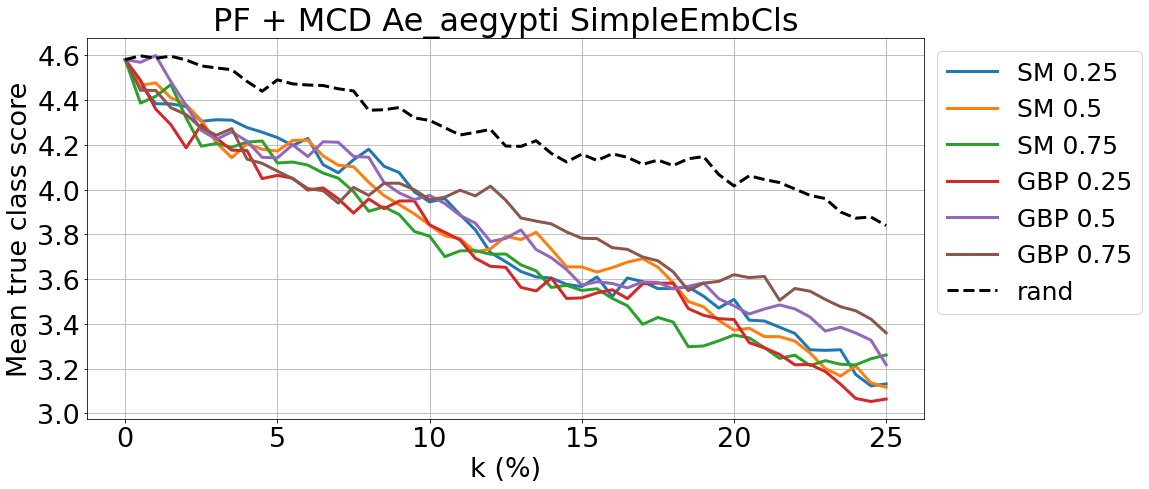

In [ ]:
fig = plt.figure(figsize=(15, 7))
for i in range(len(q_pred_scores_target)):
  plt.plot(np.linspace(0, percents, num_scores), q_pred_scores_target[i], 
           'k--' if i == 2*len(q) else '-', lw=3)
plt.title('PF + MCD ' + species[target_ind] + ' ' + model_name, fontsize = title_size)
plt.xticks(np.linspace(0, percents, percents//5+1), fontsize = ticks_size)
plt.yticks(fontsize = ticks_size)
plt.xlabel('k (%)', fontsize = label_size)
plt.ylabel('Mean true class score', fontsize = label_size)
plt.legend(sm_leg + gbp_leg + ['rand'], bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize = label_size-2)
plt.grid()
file_name = 'pot_pf_mcd_' + species[target_ind] + '_' + model_name + '.png'
fig.savefig(figures_path + file_name, bbox_inches = 'tight')
plt.show()

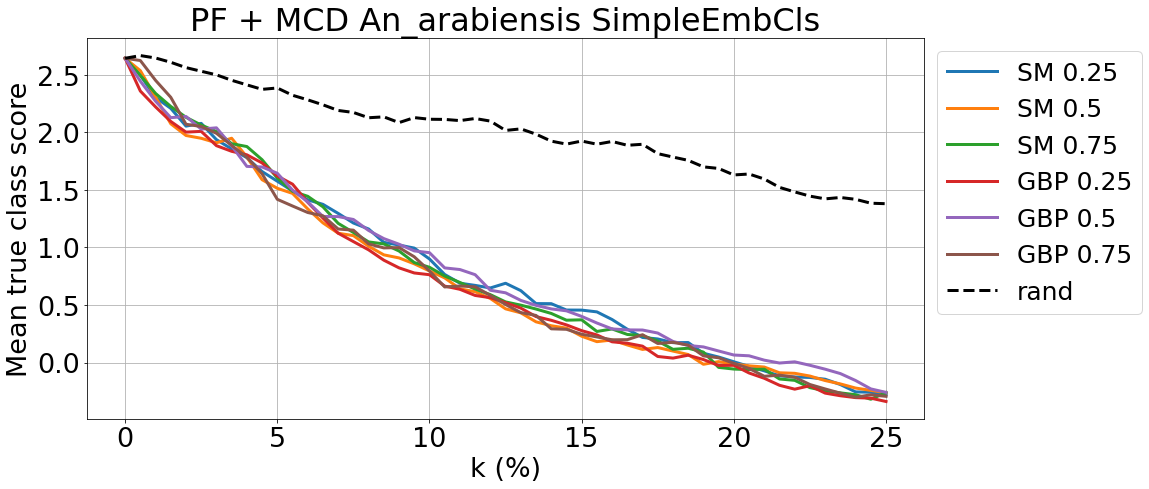

In [ ]:
fig = plt.figure(figsize=(15, 7))
for i in range(len(q_pred_scores_target)):
  plt.plot(np.linspace(0, percents, num_scores), q_pred_scores_target[i], 
           'k--' if i == 2*len(q) else '-', lw=3)
plt.title('PF + MCD ' + species[target_ind] + ' ' + model_name, fontsize = title_size)
plt.xticks(np.linspace(0, percents, percents//5+1), fontsize = ticks_size)
plt.yticks(fontsize = ticks_size)
plt.xlabel('k (%)', fontsize = label_size)
plt.ylabel('Mean true class score', fontsize = label_size)
plt.legend(sm_leg + gbp_leg + ['rand'], bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize = label_size-2)
plt.grid()
file_name = 'pot_pf_mcd_' + species[target_ind] + '_' + model_name + '.png'
fig.savefig(figures_path + file_name, bbox_inches = 'tight')
plt.show()

## MobileNet

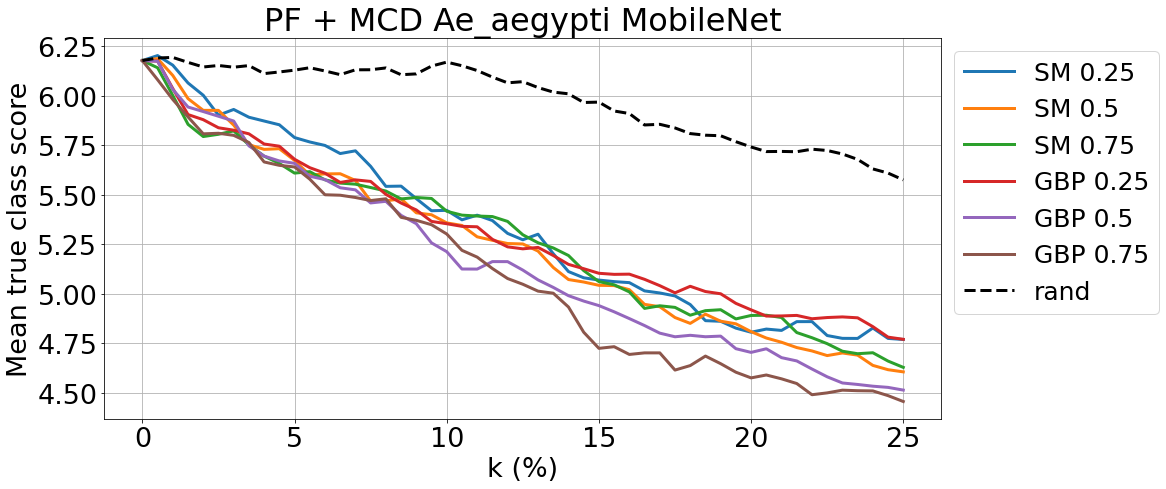

In [ ]:
fig = plt.figure(figsize=(15, 7))
for i in range(len(q_pred_scores_target)):
  plt.plot(np.linspace(0, percents, num_scores), q_pred_scores_target[i], 
           'k--' if i == 2*len(q) else '-', lw=3)
plt.title('PF + MCD ' + species[target_ind] + ' MobileNet', fontsize = title_size)
plt.xticks(np.linspace(0, percents, percents//5+1), fontsize = ticks_size)
plt.yticks(fontsize = ticks_size)
plt.xlabel('k (%)', fontsize = label_size)
plt.ylabel('Mean true class score', fontsize = label_size)
plt.legend(sm_leg + gbp_leg + ['rand'], bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize = label_size-2)
plt.grid()
file_name = 'pot_pf_mcd_' + species[target_ind] + '_MobileNet.png'
fig.savefig(figures_path + file_name, bbox_inches = 'tight')
plt.show()

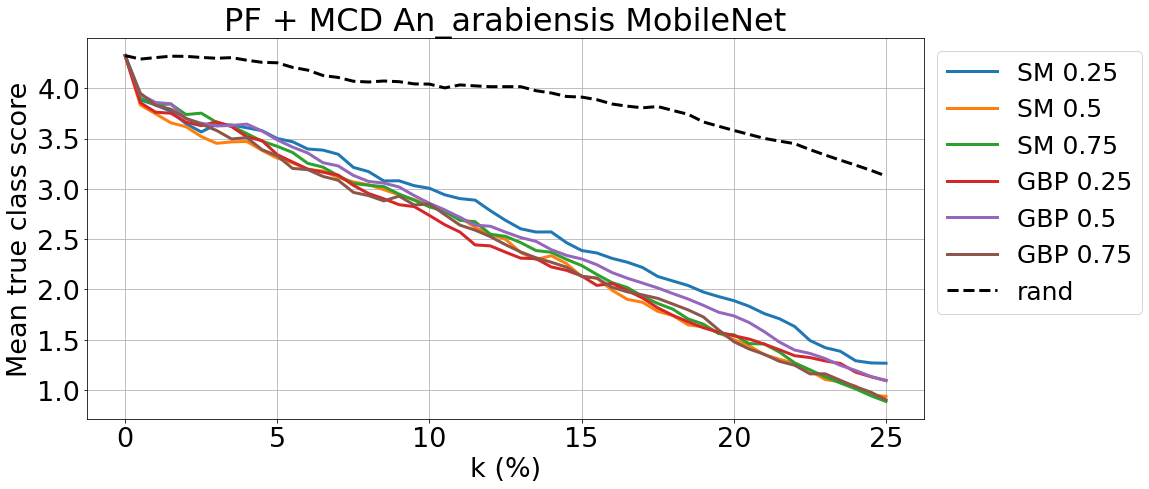

In [ ]:
fig = plt.figure(figsize=(15, 7))
for i in range(len(q_pred_scores_target)):
  plt.plot(np.linspace(0, percents, num_scores), q_pred_scores_target[i], 
           'k--' if i == 2*len(q) else '-', lw=3)
plt.title('PF + MCD ' + species[target_ind] + ' MobileNet', fontsize = title_size)
plt.xticks(np.linspace(0, percents, percents//5+1), fontsize = ticks_size)
plt.yticks(fontsize = ticks_size)
plt.xlabel('k (%)', fontsize = label_size)
plt.ylabel('Mean true class score', fontsize = label_size)
plt.legend(sm_leg + gbp_leg + ['rand'], bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize = label_size-2)
plt.grid()
file_name = 'pot_pf_mcd_' + species[target_ind] + '_MobileNet.png'
fig.savefig(figures_path + file_name, bbox_inches = 'tight')
plt.show()

# Adversarial attacks

In [ ]:
# Load different models
fbmodels = []
trim_layer_ind = [-2, -3, -3, -4] # Note: only trimming SimpleCls for consistency

for model_name, trim_ind in zip(model_names, trim_layer_ind):

  full_name  = model_name + '_' + inp_form
  print(full_name)
  model_base_dir    = pot_models_path + model_name +  '/' + inp_form + '/'
  load_weights_file = model_base_dir + full_name + '_frozen.h5'

  # Roll out models dictionary
  constructor = models_dict[model_name]['constructor']
  out_shape   = models_dict[model_name]['out_shape']
  loss        = models_dict[model_name]['loss']
  metrics     = models_dict[model_name]['metrics']

  cnn_name = 'CNN_Blocks_' + model_name
  with strategy.scope(): 
    cnn = CNN2D(drop_rate, name = cnn_name)
    
    model = constructor(in_shape, out_shape, cnn, input_name = inp_form, model_name = full_name)

    # Note: When loading weights from a frozen model, you need to first also freeze those layers again
    # Note: Don't freeze any layer in MobileNet
    cnn_layer = model.get_layer(cnn_name)
    cnn_layer.bnorm_0.trainable = False
    cnn_layer.block_1.trainable = False
    cnn_layer.block_2.trainable = False

    model.load_weights(load_weights_file)

    # Only now can you unfreeze these layers
    cnn_layer.bnorm_0.trainable = True
    cnn_layer.block_1.trainable = True
    cnn_layer.block_2.trainable = True

    # Trim other layers not related to species prediction (but add softmax back)
    model = tf.keras.models.Model(model.input, model.layers[trim_ind].output)
    softmax_output = tf.keras.layers.Softmax()(model.output)
    model = tf.keras.models.Model(model.input, softmax_output)

    model.compile(tf.keras.optimizers.Adam(), loss = loss, metrics = metrics)
    
  # Convert into FoolBox format
  model = fb.TensorFlowModel(model, bounds = (-1, 1), preprocessing = dict())
  fbmodels.append(model)

SimpleCls_spectro
SimpleEmbCls_spectro
HieraCls_spectro
HieraEmbCls_spectro


In [ ]:
# Load MobileNet and EfficientNet separately
# Note: no need to trim layers here
model_name = 'SimpleCls'
ext = '_mobile'

# Roll out models dictionary
constructor = models_dict[model_name]['constructor']
out_shape   = models_dict[model_name]['out_shape']
loss        = models_dict[model_name]['loss']
metrics     = models_dict[model_name]['metrics']

full_name  = model_name + '_' + inp_form + ext
print(full_name)

model_base_dir    = pot_models_path + model_name +  '/' + inp_form + '/'
load_weights_file = model_base_dir + full_name + '.h5' # Mobile/Efficient

# Build and compile
tf.keras.backend.clear_session() # avoid stacking graphs on one another
with strategy.scope():
  cnn = CNN_Mobile(in_shape, 0.25, drop_rate, name = 'CNN_Blocks_mobile')

  model = constructor(in_shape, out_shape, cnn, input_name = inp_form, model_name = full_name)

  # Initialize pretrained weights 
  model.load_weights(load_weights_file)

  model.compile(tf.keras.optimizers.Adam(), loss = loss, metrics = metrics)

# Convert into FoolBox format
model = fb.TensorFlowModel(model, bounds = (-1, 1), preprocessing = dict())
fbmodels.append(model)

SimpleCls_spectro_mobile


In [ ]:
# Store signals and labels from test set into separate Tensors (test_set needs to be unbatched)
for ex_specs, ex_labs in test_set.batch(8*batch_size).take(1):
  pass

In [ ]:
epsilons = [0.0, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3]
robust_accuracies = []
num_models = len(fbmodels)

for i in range(num_models):
  attack = fb.attacks.LinfDeepFoolAttack()
  raw, clipped, is_adv = attack(fbmodels[i], ex_specs, ex_labs, epsilons=epsilons)
  rob_acc = 1 - tf.reduce_mean(tf.cast(is_adv, tf.float16), axis=-1)
  robust_accuracies.append(rob_acc)

  print(str(i+1) + '/' + str(num_models))

1/5
2/5
3/5
4/5
5/5


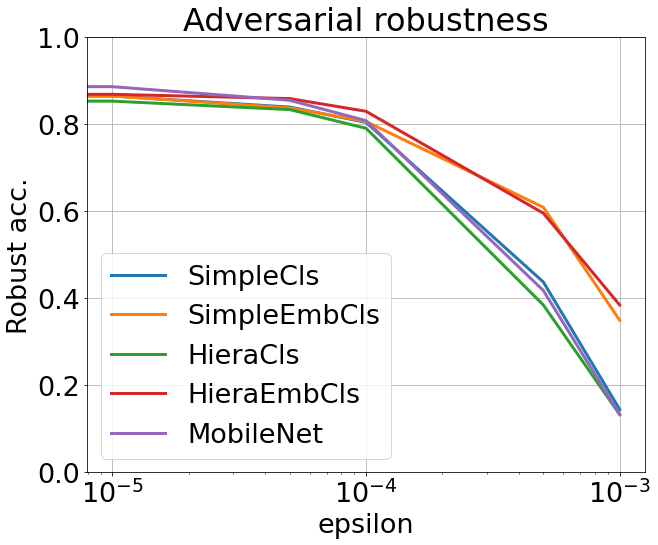

In [ ]:
plot_names = model_names + ['MobileNet']
fig = plt.figure(figsize=(10, 8))
for i in range(len(robust_accuracies)):
  plt.plot(epsilons, robust_accuracies[i], lw=3)
plt.title('Adversarial robustness', fontsize = title_size)
plt.xlabel('epsilon', fontsize = label_size)
plt.xscale("log")
plt.ylabel('Robust acc.', fontsize = label_size)
plt.xticks(fontsize = ticks_size)
plt.yticks(np.linspace(0.0, 1.0, 6), fontsize = ticks_size)
plt.legend(plot_names, fontsize = label_size)
fig.savefig(figures_path + 'pot_adv_comp.png', bbox_inches = 'tight')
plt.grid()